<a href="https://colab.research.google.com/github/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/03_action_recognition_ST_GCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ST-GCNによる動作認識

---



#骨格データからの動作認識

---



骨格データからの動作認識を行います.  
動作認識は, その人が何の動作(投げる, 蹴る, ジャンプ...)をしているかを認識するタスクです.  
動作認識には,画像などから行う手法もありますが,ここでは骨格データを使います.

###骨格データ

骨格データとは，フレームごとの関節座標です.  
しかしながら,素のデータはただの座標であり, グラフとは言えません.  

人間の構造は関節と関節の繋がりで表現できます.つまり人間はグラフとして表現できます.

ノードの特徴（座標）とエッジ（関節の繋がり）を使うことで，骨格データをグラフとして表現します.  
グラフで表現することで,関節間の関係性を考慮することができます.

グラフで表現した骨格データをGraph Convolutional Networks(GCN)に通して, 何の動作をしているかを認識します.

下の動画が，グラフ表現をした骨格データの例です.



<!--
<img src='https://drive.google.com/uc?id=1WrYd80u9buVcmBnpsgSZnzFlsYMih7Nr' width=30%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_throw_skeleton.gif?raw=true' width=30%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_throw_skeleton.gif?raw=true' width=30%>

#Spatial Temporal Graph Convolutional Networks

---



GCNを使った骨格データからの動作認識の代表的な手法として, Spatial Temporal Graph Convolutional Networks(ST-GCN)[[arXiv](https://arxiv.org/abs/1801.07455)]があります.

<!--
<img src='https://drive.google.com/uc?id=1ZRf-NF4S0P1VwMxN2DrTFPeO4EJ5if3S' width=100%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_st-gcn.png?raw=true' width=100%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_st-gcn.png?raw=true' width=100%>

ST-GCNの特徴は,骨格データを2つのグラフ構造として表現したことです.
- 空間グラフ：同一フレーム内の関節を結ぶグラフ　
- 時間グラフ：隣接フレームの同一関節を結ぶグラフ

空間グラフと時間グラフをGraph Covnolutionによって特徴を抽出することで，関節間の関係と, 時間的な変化を考慮しています. 

<!--
<img src='https://drive.google.com/uc?id=1FDOGPZxaIYs-be-6tZzPeBsrtMcBXcuv' width=30%>
-->
<!--
<img src='https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/fig/03_st_graph.png?raw=true' width=30%>
-->
<img src='https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/fig/03_st_graph.png?raw=true' width=30%>

# 実装前の準備

---




必要なモジュールのインポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

### GPU確認
今回からGPUを使用して学習します. 確認してください.

In [ ]:
print('Use CUDA:', torch.cuda.is_available())

Use CUDA: True


# データセット

---


データセットをダンロードします.今回は，小さな独自のデータセットを用意したので，それを使用します.  
動作クラス数は10クラス（0~9）です.動作は以下の通りです.
*   0:　飲む
*   1:　投げる
*   2:　座る
*   3:　立ち上がる
*   4:　拍手
*   5:　手を振る
*   6:　蹴る
*   7:　ジャンプ
*   8:　敬礼
*   9:　転倒







In [ ]:
!wget -q --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1zzPvyMLY7jlyJ3phEZRePsNKhhzspD0u' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zzPvyMLY7jlyJ3phEZRePsNKhhzspD0u" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q -o data.zip

メモ残し  
自分のgithubからダウンロード  
!wget -q https://github.com/sirakik/MPRGLecture/blob/master/15_gcn/data.zip?  raw=true -O data.zip  
MPRGのgitubからダウンロード  
!wget -q https://github.com/machine-perception-robotics-group/MPRGDeepLearningLectureNotebook/blob/master/15_gcn/data.zip?raw=true -O data.zip  
!unzip -q -o data.zip

学習データ数が2000(10クラス×200データ)，　評価データ数が200(10クラス×20データ)あります.

データの構造を確認します.


In [ ]:
test_data = np.load("data/test_data.npy")
print(test_data[0].shape)

(3, 80, 25)


(次元数，フレーム数，関節数)の構造です.  
1データあたり,3次元座標の25関節が80フレーム分入っています.

In [ ]:
# データを読み込むための関数
class Feeder(torch.utils.data.Dataset):
  def __init__(self, data_path, label_path):
      super().__init__()
      self.label = np.load(label_path)
      self.data = np.load(data_path)

  def __len__(self):
      return len(self.label)

  def __iter__(self):
      return self

  def __getitem__(self, index):
      data = np.array(self.data[index])
      label = self.label[index]

      return data, label

### 隣接行列を作成

今は座標データ（ノード特徴）しかないため，グラフではありません．  
接続関係を定義して，グラフにします．接続関係の表現には隣接行列を使用します.  
class化しておきます. モデルの定義する際に呼び出します.

隣接行列を手作業で編集するのは大変であるため，接続関係を配列で用意し，それをもとに隣接行列を作ります.

In [ ]:
class Graph():
  def __init__(self, hop_size):
    # エッジ配列を宣言します. 集合としては{{始点, 終点}, {始点, 終点}, {始点, 終点}...}のように一つのエッジを要素として宣言します.
    self.get_edge()
    
    # hop: hop数分離れた関節を結びます.
    # 例えばhop=2だと, 手首は肘だけではなく肩にも繋がっています.
    self.hop_size = hop_size 
    self.hop_dis = self.get_hop_distance(self.num_node, self.edge, hop_size=hop_size)

    # 隣接行列を作ります.ここではhop数ごとに隣接行列を作成します.
    # hopが2の時, 0hop, 1hop, 2hopの３つの隣接行列が作成されます.
    # 複数の生成方法が論文中に提案されています. 今回はわかりやすいものを使いました.
    self.get_adjacency() 

  def __str__(self):
    return self.A

  def get_edge(self):
    self.num_node = 25
    self_link = [(i, i) for i in range(self.num_node)] # ループ
    neighbor_base = [(1, 2), (2, 21), (3, 21), (4, 3), (5, 21),
                      (6, 5), (7, 6), (8, 7), (9, 21), (10, 9),
                      (11, 10), (12, 11), (13, 1), (14, 13), (15, 14),
                      (16, 15), (17, 1), (18, 17), (19, 18), (20, 19),
                      (22, 23), (23, 8), (24, 25), (25, 12)]
    neighbor_link = [(i - 1, j - 1) for (i, j) in neighbor_base]
    self.edge = self_link + neighbor_link

  def get_adjacency(self):
    valid_hop = range(0, self.hop_size + 1, 1)
    adjacency = np.zeros((self.num_node, self.num_node))
    for hop in valid_hop:
        adjacency[self.hop_dis == hop] = 1
    normalize_adjacency = self.normalize_digraph(adjacency)
    A = np.zeros((len(valid_hop), self.num_node, self.num_node))
    for i, hop in enumerate(valid_hop):
        A[i][self.hop_dis == hop] = normalize_adjacency[self.hop_dis == hop]
    self.A = A

  def get_hop_distance(self, num_node, edge, hop_size):
    A = np.zeros((num_node, num_node))
    for i, j in edge:
        A[j, i] = 1
        A[i, j] = 1
    hop_dis = np.zeros((num_node, num_node)) + np.inf
    transfer_mat = [np.linalg.matrix_power(A, d) for d in range(hop_size + 1)]
    arrive_mat = (np.stack(transfer_mat) > 0)
    for d in range(hop_size, -1, -1):
        hop_dis[arrive_mat[d]] = d
    return hop_dis

  def normalize_digraph(self, A):
    Dl = np.sum(A, 0)
    num_node = A.shape[0]
    Dn = np.zeros((num_node, num_node))
    for i in range(num_node):
        if Dl[i] > 0:
            Dn[i, i] = Dl[i]**(-1)
    DAD = np.dot(A, Dn)
    return DAD

#ST-GCN実装

---



###空間グラフの畳み込み  

まずは，空間グラフ(人間の接続パターン)のグラフ畳み込みを実装します.  
式は前回(Graph Convolutional Networksによるノード分類)に示したGraph Convolutionとほぼ同じです.
\begin{equation}
{\bf H}_{out}=\sum_{j}{\bf\tilde D}^{-\frac{1}{2}}_j{\bf\tilde A}_j{\bf\tilde D}^{-\frac{1}{2}}_j{\bf H}_{in}{\bf W}_{j}
\end{equation}
hop数分の隣接行列($j$:隣接行列の数)があるため，各隣接行列で畳み込んでから，特徴を足し合わせています.  

高速化や，今後の拡張性のため，前回のGCとは実装を変えています.


In [ ]:
class SpatialGraphConvolution(nn.Module):
  def __init__(self, in_channels, out_channels, s_kernel_size):
    super().__init__()
    self.s_kernel_size = s_kernel_size
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels * s_kernel_size,
                          kernel_size=1)
    
  def forward(self, x, A):
    x = self.conv(x)
    n, kc, t, v = x.size()
    x = x.view(n, self.s_kernel_size, kc//self.s_kernel_size, t, v)
    # 隣接行列にGCを行い, 特徴を足し合わせています.
    x = torch.einsum('nkctv,kvw->nctw', (x, A))
    return x.contiguous()

###時間グラフの畳み込み

時間グラフは,グラフ畳み込み処理ではなく一般的な2d畳み込み処理で実装できます.  
特徴マップは（フレーム数×関節数)の形になっています. 同一関節をフレーム方向に繋いだものが時間グラフです.  
フレーム方向に畳み込めばいいため（$T\times 1$）の2d畳み込みフィルターで実装できます.

また, ST-GCNは, 空間グラフと時間グラフの畳み込みを交互に行います.  
これを繰り返すので, 空間グラフと時間グラフ，その他(活性化関数やdropout)を備えたクラス(STGC_block)を作っておきます.

In [ ]:
class STGC_block(nn.Module):
  def __init__(self, in_channels, out_channels, stride, t_kernel_size, A_size, dropout=0.5):
    super().__init__()
    # 空間グラフの畳み込み
    self.sgc = SpatialGraphConvolution(in_channels=in_channels,
                                       out_channels=out_channels,
                                       s_kernel_size=A_size[0])
    
    # Learnable weight matrix M エッジに重みを与えます. どのエッジが重要かを学習します.
    self.M = nn.Parameter(torch.ones(A_size))

    self.tgc = nn.Sequential(nn.BatchNorm2d(out_channels),
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Conv2d(out_channels,
                                      out_channels,
                                      (t_kernel_size, 1),
                                      (stride, 1),
                                      ((t_kernel_size - 1) // 2, 0)),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU())

  def forward(self, x, A):
    x = self.tgc(self.sgc(x, A * self.M))
    return x

###ネットワークモデル

In [ ]:
class ST_GCN(nn.Module):
  def __init__(self, num_classes, in_channels, t_kernel_size, hop_size):
    super().__init__()
    # グラフ作成
    graph = Graph(hop_size)
    A = torch.tensor(graph.A, dtype=torch.float32, requires_grad=False)
    self.register_buffer('A', A)
    A_size = A.size()
  
    # Batch Normalization
    self.bn = nn.BatchNorm1d(in_channels * A_size[1])
    
    # STGC_blocks
    self.stgc1 = STGC_block(in_channels, 32, 1, t_kernel_size, A_size)
    self.stgc2 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc3 = STGC_block(32, 32, 1, t_kernel_size, A_size)
    self.stgc4 = STGC_block(32, 64, 2, t_kernel_size, A_size)
    self.stgc5 = STGC_block(64, 64, 1, t_kernel_size, A_size)
    self.stgc6 = STGC_block(64, 64, 1, t_kernel_size, A_size)

    # Prediction
    self.fc = nn.Conv2d(64, num_classes, kernel_size=1)

  def forward(self, x):
    # Batch Normalization
    N, C, T, V = x.size() # batch, channel, frame, node
    x = x.permute(0, 3, 1, 2).contiguous().view(N, V * C, T)
    x = self.bn(x)
    x = x.view(N, V, C, T).permute(0, 2, 3, 1).contiguous()

    # STGC_blocks
    x = self.stgc1(x, self.A)
    x = self.stgc2(x, self.A)
    x = self.stgc3(x, self.A)
    x = self.stgc4(x, self.A)
    x = self.stgc5(x, self.A)
    x = self.stgc6(x, self.A)

    # Prediction
    x = F.avg_pool2d(x, x.size()[2:])
    x = x.view(N, -1, 1, 1)
    x = self.fc(x)
    x = x.view(x.size(0), -1)
    return x

#学習

---



In [ ]:
NUM_EPOCH = 100
BATCH_SIZE = 64

# モデルを作成
model = ST_GCN(num_classes=10, 
                  in_channels=3,
                  t_kernel_size=9, # 時間グラフ畳み込みのカーネルサイズ (t_kernel_size × 1)
                  hop_size=2).cuda()

# オプティマイザ
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 誤差関数
criterion = torch.nn.CrossEntropyLoss()

# データセットの用意
data_loader = dict()
data_loader['train'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/train_data.npy', label_path='data/train_label.npy'), batch_size=BATCH_SIZE, shuffle=True,)
data_loader['test'] = torch.utils.data.DataLoader(dataset=Feeder(data_path='data/test_data.npy', label_path='data/test_label.npy'), batch_size=BATCH_SIZE, shuffle=False)

# モデルを学習モードに変更
model.train()

# 学習開始
for epoch in range(1, NUM_EPOCH+1):
  correct = 0
  sum_loss = 0
  for batch_idx, (data, label) in enumerate(data_loader['train']):
    data = data.cuda()
    label = label.cuda()

    output = model(data)

    loss = criterion(output, label)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

  print('# Epoch: {} | Loss: {:.4f} | Accuracy: {:.4f}'.format(epoch, sum_loss/len(data_loader['train'].dataset), (100. * correct / len(data_loader['train'].dataset))))

# Epoch: 1 | Loss: 0.0362 | Accuracy: 15.2500
# Epoch: 2 | Loss: 0.0348 | Accuracy: 21.0500
# Epoch: 3 | Loss: 0.0335 | Accuracy: 24.2500
# Epoch: 4 | Loss: 0.0326 | Accuracy: 25.3000
# Epoch: 5 | Loss: 0.0316 | Accuracy: 28.1500
# Epoch: 6 | Loss: 0.0299 | Accuracy: 31.8500
# Epoch: 7 | Loss: 0.0286 | Accuracy: 36.2000
# Epoch: 8 | Loss: 0.0267 | Accuracy: 41.9500
# Epoch: 9 | Loss: 0.0236 | Accuracy: 47.1500
# Epoch: 10 | Loss: 0.0211 | Accuracy: 54.5000
# Epoch: 11 | Loss: 0.0189 | Accuracy: 58.5500
# Epoch: 12 | Loss: 0.0179 | Accuracy: 59.2500
# Epoch: 13 | Loss: 0.0171 | Accuracy: 61.4000
# Epoch: 14 | Loss: 0.0167 | Accuracy: 62.9000
# Epoch: 15 | Loss: 0.0165 | Accuracy: 63.1500
# Epoch: 16 | Loss: 0.0162 | Accuracy: 63.3000
# Epoch: 17 | Loss: 0.0155 | Accuracy: 65.5000
# Epoch: 18 | Loss: 0.0151 | Accuracy: 66.8000
# Epoch: 19 | Loss: 0.0139 | Accuracy: 71.6000
# Epoch: 20 | Loss: 0.0132 | Accuracy: 71.0500
# Epoch: 21 | Loss: 0.0127 | Accuracy: 72.5500
# Epoch: 22 | Loss: 0.

#評価

---



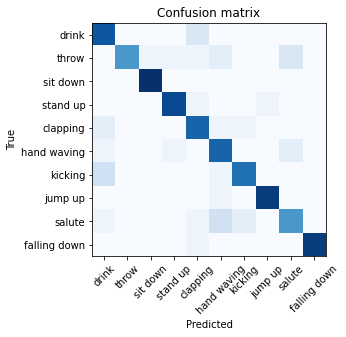

# Test Accuracy: 82.000[%]


In [ ]:
# モデルを評価モードに変更
model.eval()

correct = 0
confusion_matrix = np.zeros((10, 10))
with torch.no_grad():
  for batch_idx, (data, label) in enumerate(data_loader['test']):
    data = data.cuda()
    label = label.cuda()

    output = model(data)

    _, predict = torch.max(output.data, 1)
    correct += (predict == label).sum().item()

    for l, p in zip(label.view(-1), predict.view(-1)):
      confusion_matrix[l.long(), p.long()] += 1

len_cm = len(confusion_matrix)
for i in range(len_cm):
    sum_cm = np.sum(confusion_matrix[i])
    for j in range(len_cm):
        confusion_matrix[i][j] = 100 * (confusion_matrix[i][j] / sum_cm)

classes = ['drink', 'throw', 'sit down', 'stand up', 'clapping', 'hand waving', 'kicking', 'jump up', 'salute', 'falling down']
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.tight_layout()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()


print('# Test Accuracy: {:.3f}[%]'.format(100. * correct / len(data_loader['test'].dataset)))